In [684]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [685]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fmin_l_bfgs_b
from time import time
from tqdm import tqdm
import jax
import jax.numpy as jnp

from picard import amari_distance
from multiviewica_delay import permica, multiviewica_delay

from apply_dilations_shifts import apply_dilations_shifts, apply_dilations_shifts_3d_jax
from generate_data import generate_data, generate_new_data
from plot_functions import (
    plot_sources_2d,
    plot_sources_3d,
    scatter_plot_shifts_or_dilations,
    plot_params_across_iters,
    plot_sources_3_steps,
    plot_amari_across_iters,
)
from other_functions import compute_lambda, Memory_callback
from permica_preprocessing import (
    find_delays_permica,
    _find_ordering,
    find_order,
    find_sign,
    grid_search_orders_dilations_shifts,
    permica_preprocessing,
)
from lbfgsb_loss_and_grad import loss

In [686]:
jax.config.update('jax_enable_x64', True)

# parameters

In [687]:
m = 5
p = 3
n = 600
max_shift = 0.05
max_dilation = 1.2
bounds_factor = 1.2
noise_data = 0.05  # 0.01 with previous generate_data function
noise_model = 1  # 1 by default
S1_S2_scale = 0.7  # 1 for first function, 0 for second function, 0.5 (for example) for a mixture of both
n_bins = 10  # should divide n
freq_level = 50
number_of_filters_squarenorm_f = 0
filter_length_squarenorm_f = 3
use_envelop_term = True
number_of_filters_envelop = 1
filter_length_envelop = 10
compute_shift_dilation_scale_hessian = True
W_scale = 5
random_state = 395
n_concat = 3  # should divide n

List of tested random states:
- 3661: perfect
- 1571: pb with permica and thus bad Amari distance
- 8382: small sign pb with permica and ok Amari distance
- 742181: pb with permica but good Amari distance
- 67811: small sign pb with permica and bad Amari distance (maybe because sources are too sharp?)
- 618617: pb with permica and pretty bad Amari distance
- 9863: mid Amari distance
- 9544: mid Amari distance

In [688]:
rng = np.random.RandomState(random_state)

# generate data

In [689]:
# X_list, A_list, dilations, shifts, S_list, S = generate_data(
#     m=m,
#     p=p,
#     n=n,
#     max_shift=max_shift,
#     max_dilation=max_dilation,
#     noise_data=noise_data,
#     n_bins=n_bins,
#     freq_level=freq_level,
#     S1_S2_scale=S1_S2_scale,
#     rng=rng,
#     n_concat=n_concat,
# )

X_list, A_list, dilations, shifts, S_list, S = generate_new_data(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    rng=rng,
    n_concat=n_concat,
)

# plot true sources

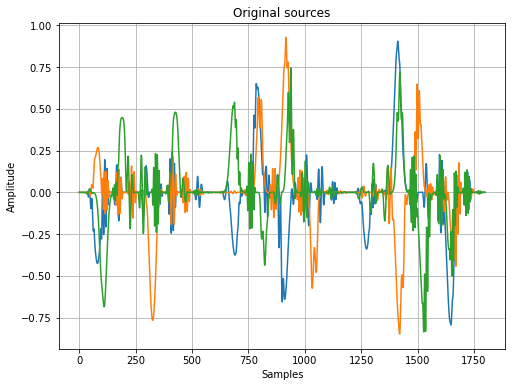

In [690]:
plot_sources_2d(S)

In [691]:
# # plot the first concatenation of the shared sources
# fig, ax = plt.subplots(figsize=(10, 6))
# for i in range(p):
#     plt.plot(S[i] - i, label=f"source {i}")
# plt.xlim([0, n])
# plt.legend()
# ax.set_yticklabels([])
# plt.xlabel("Samples")
# plt.ylabel("Amplitude")
# plt.title("Shared sources")
# plt.grid()
# plt.tight_layout()
# plt.show()

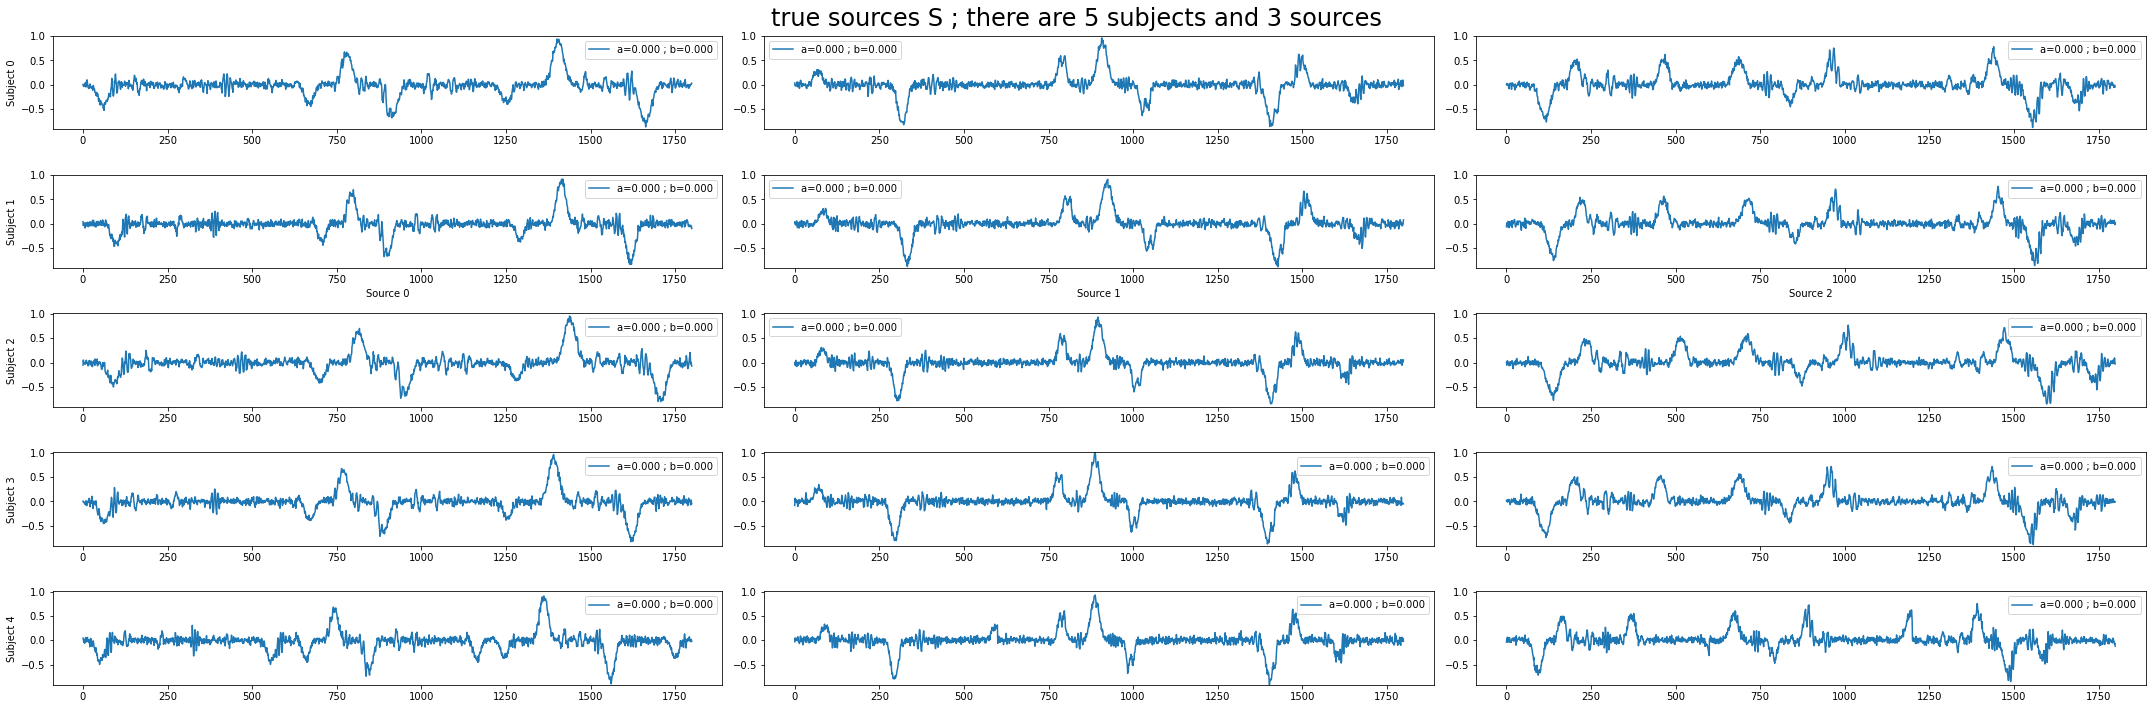

In [692]:
plot_sources_3d(S_list);

# shift scale and dilation scale

In [693]:
if max_shift > 0:
    shift_scale = W_scale / max_shift  # scalar
else:
    shift_scale = 1.
if max_dilation > 1:
    dilation_scale = W_scale / (max_dilation - 1)  # scalar
    if compute_shift_dilation_scale_hessian:
        lambdas = np.array([[compute_lambda(s, n_concat=n_concat) for s in S] for S in S_list])
        dilation_scale *= lambdas  # (m, p) matrix
else:
    dilation_scale = 1.

In [694]:
max_dilation_2 = 1 + bounds_factor * (max_dilation - 1)
max_shift_2 = bounds_factor * max_shift

# initialize W, dilations and shifts

In [695]:
# initialize W_list and S_list with permica
max_delay = (1 + max_shift) * max_dilation - 1
max_delay_samples = np.ceil(max_delay * n).astype("int")
_, W_list_init, _, _ = permica(
    X_list, max_iter=1000, random_state=random_state, tol=1e-9,
    optim_delays=True, max_delay=max_delay_samples)
S_list_init = np.array([np.dot(W, X) for W, X in zip(W_list_init, X_list)])

In [696]:
# linear in m and p
S_list_init, W_list_init = permica_preprocessing(
    S_list_init, W_list_init, max_dilation, max_shift, n_concat, nb_points_grid=10, S_list_true=S_list)

Smoothing...
Finding order, dilation and shift for each source of each subject...


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

order : [[0 1 2]
 [0 1 2]
 [0 2 1]
 [0 1 2]
 [0 1 2]]
Finding sign...
Finding the same order as in the true sources...
Aligning back...


In [697]:
# find_delays_order_permica = True
# if find_delays_order_permica:
#     orders_init, dilations_init, shifts_init = grid_search_orders_dilations_shifts(
#         S_list_init, max_dilation=1+2*(max_dilation-1), max_shift=2*max_shift, n_concat=n_concat, nb_points_grid=30)
#     S_list_init = apply_dilations_shifts_3d_jax(
#         S_list_init, dilations_init, shifts_init, max_dilation=1+2*(max_dilation-1),
#         max_shift=2*max_shift, shift_before_dilation=False, n_concat=n_concat)
#     W_list_init = np.array([W_list_init[i][orders_init[i]] for i in range(m)])
#     S_list_init = np.array([S_list_init[i][orders_init[i]] for i in range(m)])

In [698]:
# # find sources' order for each subject by allowing sources to be delayed
# find_delays_order_permica = True
# if find_delays_order_permica:
#     _, S_list_init = find_delays_permica(S_list_init, max_delay_samples, delay_step=30)
#     orders, signs, _ = _find_ordering(S_list_init)
#     for i, (order, sign) in enumerate(zip(orders, signs)):
#         W_list_init[i] = sign[:, None] * W_list_init[i][order, :]
#     S_list_init = np.array([np.dot(W, X) for W, X in zip(W_list_init, X_list)])

In [699]:
# # find the order that aligns S_list and S_list_init
# order_S_list_S_list_init = True
# if order_S_list_S_list_init:
#     order = find_order(np.mean(S_list, axis=0), np.mean(S_list_init, axis=0))
#     W_list_init = W_list_init[:, order, :]
#     S_list_init = S_list_init[:, order, :]
# signs_S_list_init = False
# if signs_S_list_init:
#     signs = find_sign(S_list_init)
#     W_list_init *= np.repeat(signs, p, axis=1).reshape(m, p, p)
#     S_list_init *= np.repeat(signs, n_concat*n, axis=1).reshape(m, p, n_concat*n)

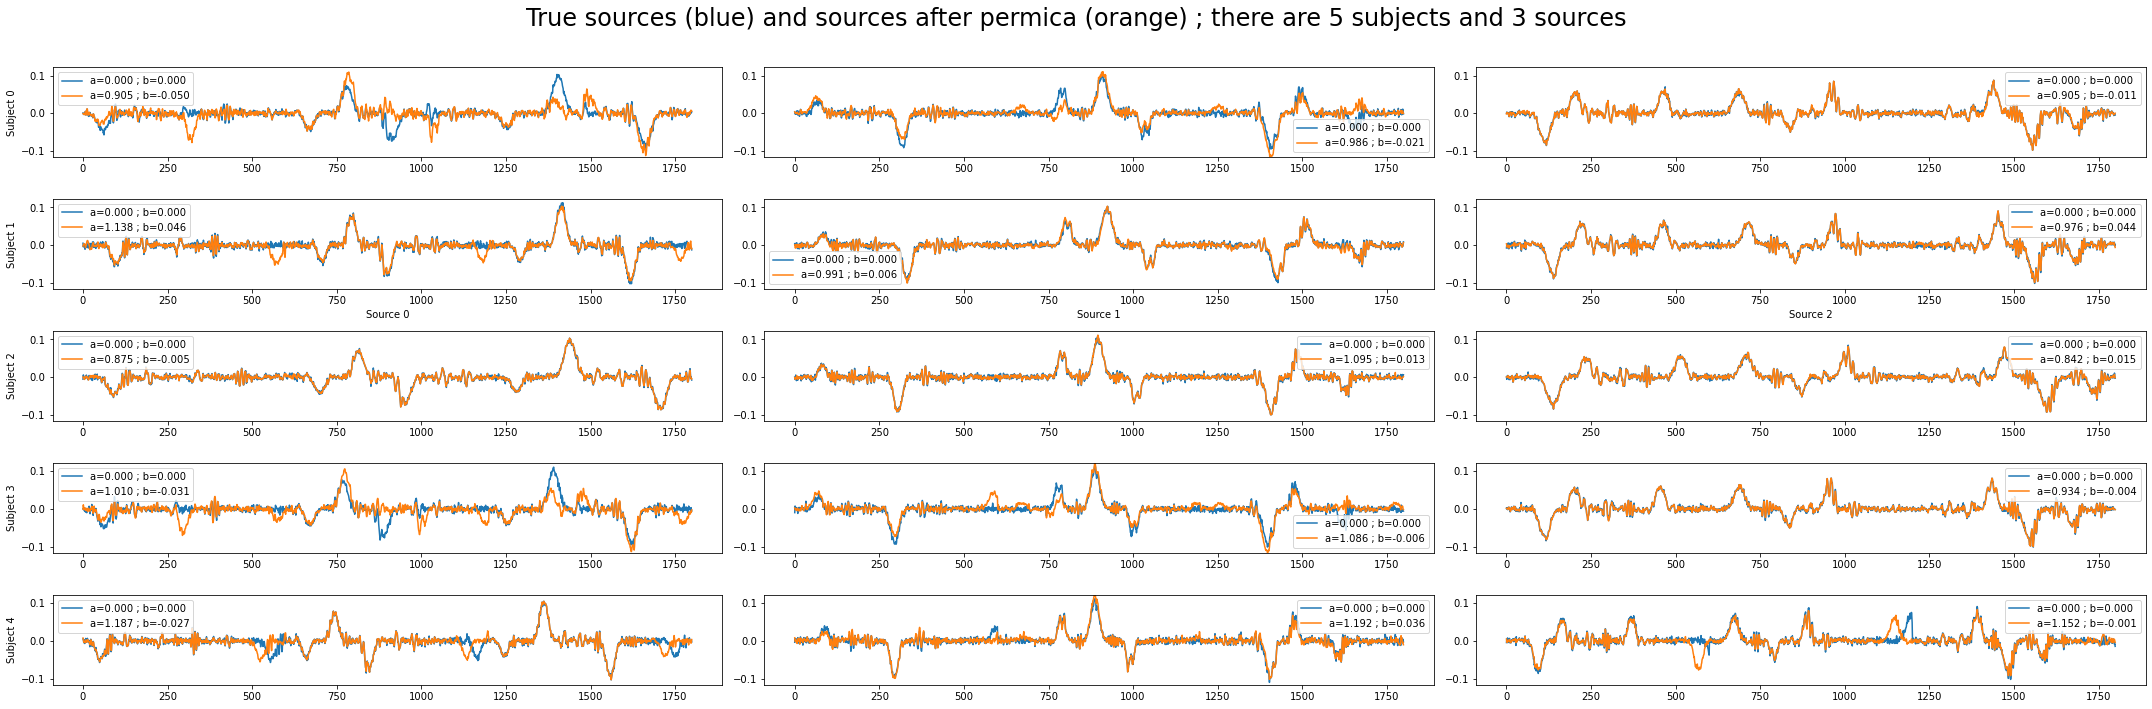

In [700]:
axes = plot_sources_3d(S_list / np.linalg.norm(S_list, axis=-1, keepdims=True), show=False)
plot_sources_3d(S_list_init / np.linalg.norm(S_list_init, axis=-1, keepdims=True),
                dilations=dilations, shifts=shifts, axes=axes,
                title="True sources (blue) and sources after permica (orange)");

Sometimes orders, dilations and shifts are badly estimated. This is partially due to a bad optimization during permica.

In [701]:
# Amari distance at init
amari_init = np.mean([amari_distance(W, A) for W, A in zip(W_list_init, A_list)])
print(f"Amari distance after permica : {amari_init}")

Amari distance after permica : 0.1411853723427202


In [702]:
# initialize A and B
A_init = jnp.ones((m, p)) * dilation_scale
B_init = jnp.zeros((m, p))
W_A_B_init = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(A_init), jnp.ravel(B_init)])

# jit

In [703]:
args = (
    W_A_B_init,
    X_list,
    dilation_scale,
    shift_scale,
    max_shift_2,
    max_dilation_2,
    noise_model,
    number_of_filters_envelop,
    filter_length_envelop,
    number_of_filters_squarenorm_f,
    filter_length_squarenorm_f,
    use_envelop_term,
    n_concat,
)

In [704]:
# arguments 1 and 2 have to be static because they are np.ndarray
val_and_grad = jax.jit(jax.value_and_grad(loss), static_argnums=tuple(np.arange(3, 13)))

In [705]:
def wrapper_loss_and_grad(*args):
    val, grad = val_and_grad(*args)
    return val, np.array(grad)

def jit_wrapper(*args):
    print("Jit...")
    start = time()
    wrapper_loss_and_grad(*args)
    print(f"Jit time : {time() - start}")

In [706]:
jit_wrapper(*args)

Jit...
Jit time : 3.1828300952911377


# LBFGSB

In [707]:
# bounds
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p**2)
if compute_shift_dilation_scale_hessian:
    bounds_A = [
        (
            1 / max_dilation_2 * dilation_scale.ravel()[i],
            max_dilation_2 * dilation_scale.ravel()[i],
        )
        for i in range(m * p)
    ]
else:
    bounds_A = [
        (1 / max_dilation_2 * dilation_scale, max_dilation_2 * dilation_scale)
    ] * (m * p)
bounds_B = [(-max_shift_2 * shift_scale, max_shift_2 * shift_scale)] * (m * p)
bounds_W_A_B = jnp.array(bounds_W + bounds_A + bounds_B)

In [708]:
# LBFGSB
callback = Memory_callback(m, p, dilation_scale, shift_scale)

print("LBFGSB...")
start = time()
res = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=args[0],
    args=args[1:],
    bounds=bounds_W_A_B,
    disp=True,
    # factr=1e9,
    factr=1e3,
    # pgtol=1e-8,
    pgtol=1e-5,
    maxiter=3000,
    callback=callback,
)
print(f"LBFGSB time : {time() - start}")

LBFGSB...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98386D+01    |proj g|=  2.47347D+01

At iterate    1    f=  1.46633D+01    |proj g|=  3.29582D+00

At iterate    2    f=  1.22819D+01    |proj g|=  2.50257D+00

At iterate    3    f=  5.36939D+00    |proj g|=  1.38745D+00

At iterate    4    f=  9.17692D-02    |proj g|=  8.52979D-01

At iterate    5    f= -5.16415D+00    |proj g|=  5.08156D-01

At iterate    6    f= -9.30384D+00    |proj g|=  2.88369D-01

At iterate    7    f= -1.28231D+01    |proj g|=  2.71677D-01

At iterate    8    f= -1.47335D+01    |proj g|=  7.06159D-01

At iterate    9    f= -1.67138D+01    |proj g|=  2.71258D-01

At iterate   10    f= -1.73323D+01    |proj g|=  1.53943D-01

At iterate   11    f= -1.80754D+01    |proj g|=  3.55912D-01

At iterate   12    f= -1.86572D+01    |proj g|=  2.74689D-01

At iterate   13 

In [709]:
memory_W = np.array(callback.memory_W)
memory_A = np.array(callback.memory_A)
memory_B = np.array(callback.memory_B)

W = memory_W[-1]
A = 1 / memory_A[-1]
B = -memory_B[-1]

# plot dilations and shifts

In [710]:
# # center and reduce
# dilations_cr = (dilations - np.mean(dilations, axis=0)) / np.std(dilations, axis=0)
# shifts_cr = (shifts - np.mean(shifts, axis=0)) / np.std(shifts, axis=0)
# A_cr = (A - np.mean(A, axis=0)) / np.std(A, axis=0)
# B_cr = (B - np.mean(B, axis=0)) / np.std(B, axis=0)

# only center
dilations_c = dilations - np.mean(dilations, axis=0) + 1
shifts_c = shifts - np.mean(shifts, axis=0)
A_c = A - np.mean(A, axis=0) + 1
B_c = B - np.mean(B, axis=0)

In [711]:
# errors
# errors_A = np.mean((dilations_cr - A_cr) ** 2)
errors_A = np.mean((dilations_c - A_c) ** 2)
# errors_B = np.mean((shifts_cr - B_cr) ** 2)
errors_B = np.mean((shifts_c - B_c) ** 2)

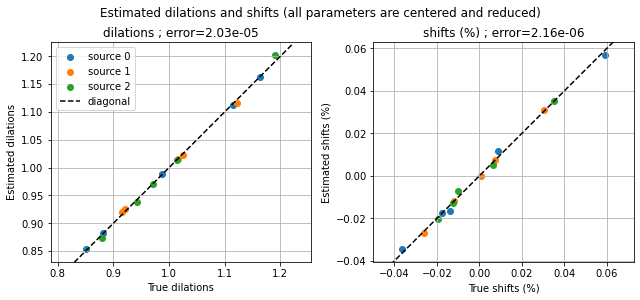

In [712]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

[ax.axis("equal") for ax in axes]
[ax.grid(True) for ax in axes]

# scatter_plot_shifts_or_dilations(dilations_cr, A_cr, errors_A, dilations_not_shifts=True, legend=True)
scatter_plot_shifts_or_dilations(
    dilations_c,
    A_c,
    errors_A,
    dilations_not_shifts=True,
    legend=True,
    ax=axes[0],
)
# scatter_plot_shifts_or_dilations(shifts_cr, B_cr, errors_B, dilations_not_shifts=False, legend=False)
scatter_plot_shifts_or_dilations(
    shifts_c,
    B_c,
    errors_B,
    dilations_not_shifts=False,
    legend=False,
    ax=axes[1],
)
fig.suptitle(
    f"Estimated dilations and shifts (all parameters are centered and reduced)",
    y=1.03,
)
plt.show()

# zoom on a specific source

In [713]:
source_number = 0

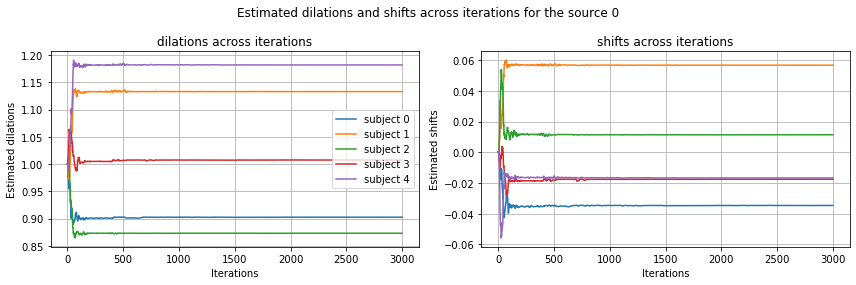

In [714]:
# Estimated dilations and shifts across iterations for one source
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_params_across_iters(1/memory_A[:, :, source_number], dilations_not_shifts=True, legend=True)
plt.subplot(1, 2, 2)
plot_params_across_iters(-memory_B[:, :, source_number], dilations_not_shifts=False, legend=False)
plt.suptitle(f"Estimated dilations and shifts across iterations for the source {source_number}")
plt.tight_layout()
plt.show()

In [715]:
S_list_lbfgsb_3d = jnp.array([jnp.dot(W_, X) for W_, X in zip(W, X_list)])
S_list_lbfgsb_4d = jnp.moveaxis(jnp.array(jnp.split(S_list_lbfgsb_3d, n_concat, axis=-1)), source=0, destination=2)
Y_list_lbfgsb_4d = apply_dilations_shifts(
    S_list_lbfgsb_4d, dilations=1/A, shifts=-B, max_shift=max_shift_2, 
    max_dilation=max_dilation_2, shift_before_dilation=False)
Y_list_lbfgsb_3d = Y_list_lbfgsb_4d.reshape((m, p, -1))

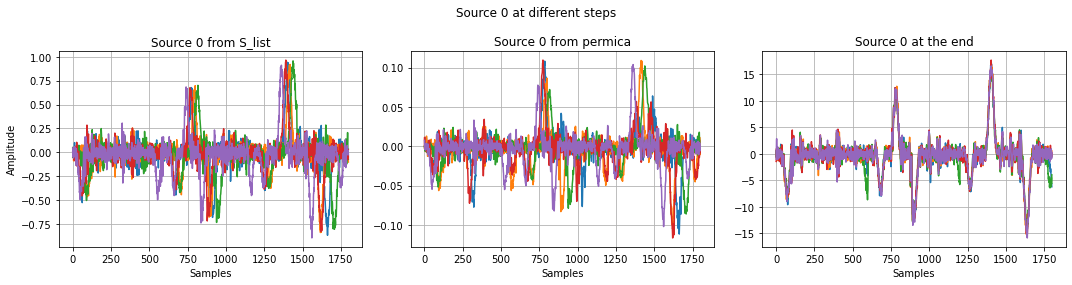

In [716]:
# plot true sources, sources after permica and sources after LBFGSB
plot_sources_3_steps(S_list, S_list_init, Y_list_lbfgsb_3d, source_number=source_number)

# MVICAD

In [717]:
# MVICAD max_delay=max_shift
start = time()
_, W_mvicad, S_mvicad, _, shifts_mvicad, _ = multiviewica_delay(
    X_list,
    init=W_list_init,
    shared_delays=False,
    max_delay=int(max_shift*n),
    random_state=random_state,
    continuous_delays=False,
)
print(f"MVICAD (max_delay={int(max_shift*n)}) time : {time() - start}")
shifts_mvicad[shifts_mvicad > n // 2] -= n_concat * n
shifts_mvicad = shifts_mvicad / n  # cannot use /= because shifts_mvicad contains integers and not floats
# shifts_mvicad_cr = (shifts_mvicad - np.mean(shifts_mvicad, axis=0)) / np.std(shifts_mvicad, axis=0)
shifts_mvicad_c = shifts_mvicad - np.mean(shifts_mvicad, axis=0)
# error_mvicad = np.mean((shifts_cr - shifts_mvicad_cr) ** 2)
error_mvicad = np.mean((shifts_c - shifts_mvicad_c) ** 2)

MVICAD (max_delay=30) time : 0.13794779777526855


In [718]:
# MVICAD max_delay=max_delay
start = time()
_, W_mvicad_2, S_mvicad_2, _, shifts_mvicad_2, _ = multiviewica_delay(
    X_list,
    init=W_list_init,
    shared_delays=False,
    max_delay=max_delay_samples,
    random_state=random_state,
    continuous_delays=False,
)
print(f"MVICAD (max_delay={max_delay_samples}) time : {time() - start}")
shifts_mvicad_2[shifts_mvicad_2 > n // 2] -= n_concat * n
shifts_mvicad_2 = shifts_mvicad_2 / n  # cannot use /= because shifts_mvicad_2 contains integers and not floats
# shifts_mvicad_cr_2 = (shifts_mvicad_2 - np.mean(shifts_mvicad_2, axis=0)) / np.std(shifts_mvicad_2, axis=0)
shifts_mvicad_c_2 = shifts_mvicad_2 - np.mean(shifts_mvicad_2, axis=0)
# error_mvicad_2 = np.mean((shifts_cr - shifts_mvicad_cr_2) ** 2)
error_mvicad_2 = np.mean((shifts_c - shifts_mvicad_c_2) ** 2)

MVICAD (max_delay=156) time : 0.1595749855041504


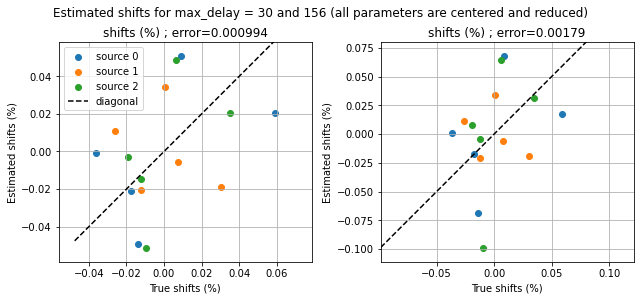

In [719]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

[ax.axis("equal") for ax in axes]
[ax.grid(True) for ax in axes]

# scatter_plot_shifts_or_dilations(dilations_cr, A_cr, errors_A, dilations_not_shifts=True, legend=True)
scatter_plot_shifts_or_dilations(
    shifts_c,
    shifts_mvicad_c,
    error_mvicad,
    dilations_not_shifts=False,
    legend=True,
    ax=axes[0],
)
# scatter_plot_shifts_or_dilations(shifts_cr, B_cr, errors_B, dilations_not_shifts=False, legend=False)
scatter_plot_shifts_or_dilations(
    shifts_c,
    shifts_mvicad_c_2,
    error_mvicad_2,
    dilations_not_shifts=False,
    legend=False,
    ax=axes[1],
)
fig.suptitle(
    f"Estimated shifts for max_delay = {int(max_shift*n)} and {max_delay_samples} (all parameters are centered and reduced)",
    y=1.03,
)
plt.show()

In [720]:
amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
amari_mvicad_2 = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad_2, A_list)])
print(f"Amari distance MVICAD (with max_shift = {int(max_shift*n)}) : {amari_mvicad}")
print(f"Amari distance MVICAD (with max_shift = {max_delay_samples}) : {amari_mvicad_2}")

Amari distance MVICAD (with max_shift = 30) : 0.004222907533590188
Amari distance MVICAD (with max_shift = 156) : 0.011154332092560337


# plot Amari distance

In [721]:
amari_rand = 0
n_iter_rand = 10
for _ in range(n_iter_rand):
    W_list_rand = rng.randn(m, p, p)
    amari_rand += np.mean([amari_distance(W, A) for W, A in zip(W_list_rand, A_list)])
amari_rand /= n_iter_rand
print(f"Amari distance random : {amari_rand}")

Amari distance random : 0.5770525077744277


In [722]:
amari_lbfgsb = [amari_init]
for W_list in tqdm(callback.memory_W):
    amari_lbfgsb.append(np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)]))

100%|██████████| 3000/3000 [00:00<00:00, 4682.64it/s]


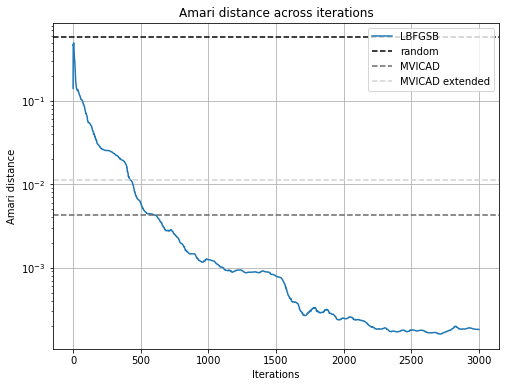

In [723]:
plot_amari_across_iters(amari_lbfgsb, amari_rand, amari_mvicad, amari_mvicad_2)

# sources found by LBFGSB and MVICAD

In [724]:
S_list_mvicad_2 = np.array([np.dot(W, X) for W, X in zip(W_mvicad_2, X_list)])
S_list_mvicad_2_4d = jnp.moveaxis(jnp.array(jnp.split(S_list_mvicad_2, n_concat, axis=-1)), source=0, destination=2)
Y_list_mvicad_2 = apply_dilations_shifts(
    S_list_mvicad_2_4d, dilations=np.ones((m, p)), shifts=-shifts_mvicad_2,
    max_dilation=1., max_shift=max_delay)
Y_list_mvicad_2 = Y_list_mvicad_2.reshape((m, p, -1))

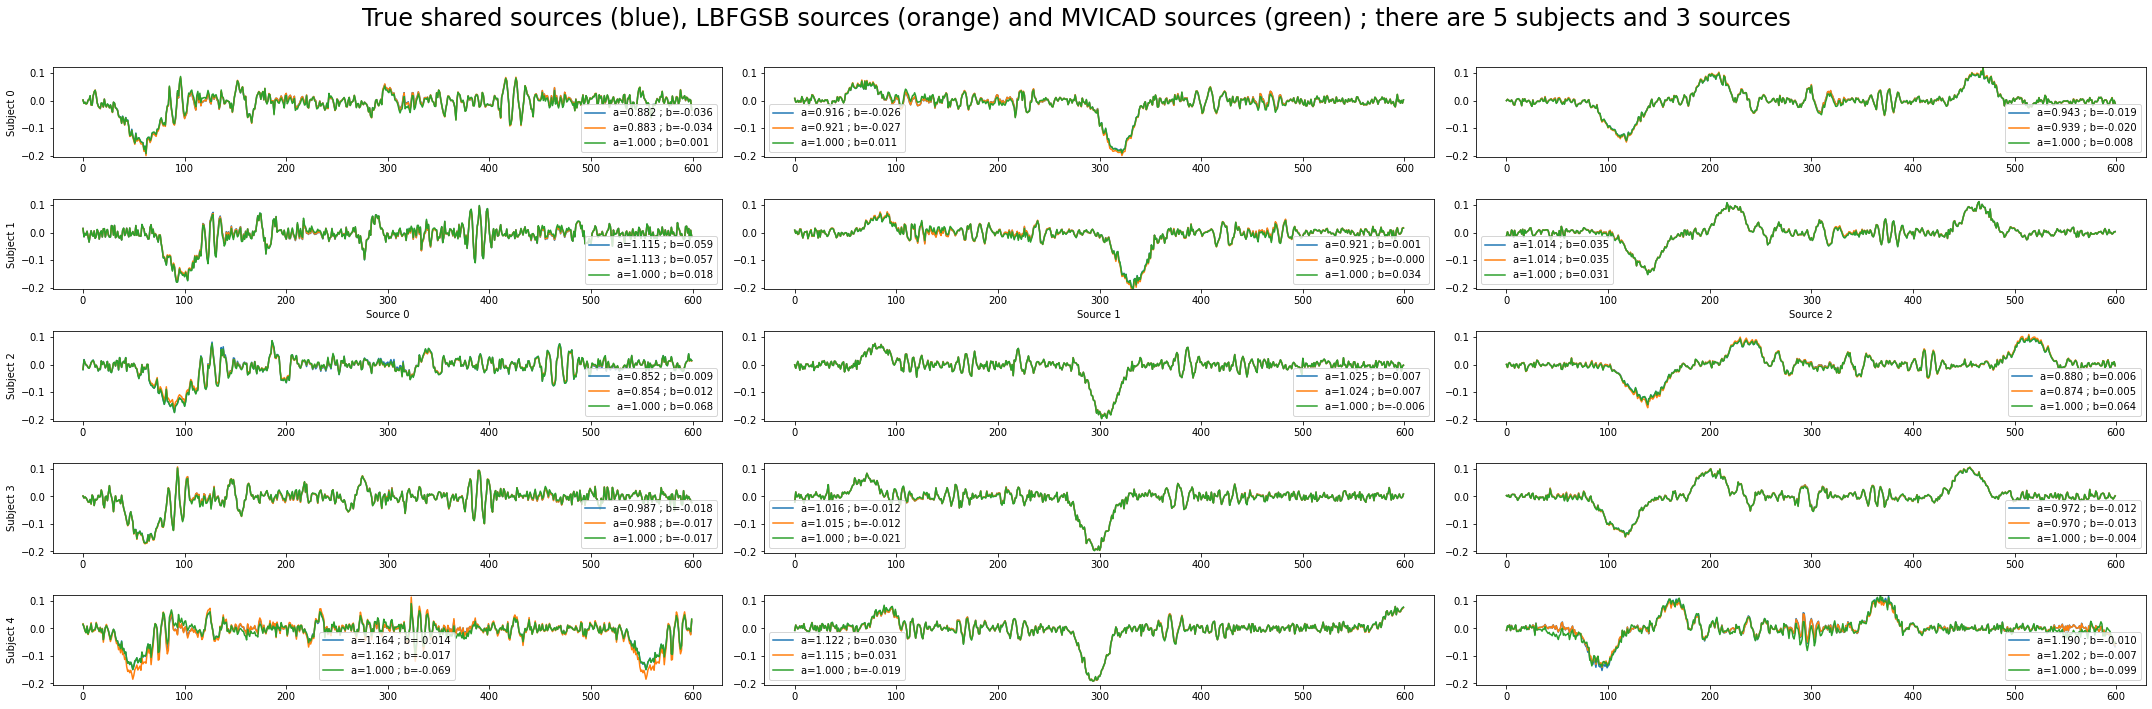

In [725]:
S_rep = np.array([S] * m)
min_sample = 0
max_sample = n
axes = plot_sources_3d(
    S_list[:, :, min_sample:max_sample] / np.linalg.norm(S_list[:, :, min_sample:max_sample], axis=-1, keepdims=True),
    dilations=dilations_c, shifts=shifts_c, show=False)
plot_sources_3d(
    S_list_lbfgsb_3d[:, :, min_sample:max_sample] / np.linalg.norm(Y_list_lbfgsb_3d[:, :, min_sample:max_sample], axis=-1, keepdims=True),
    dilations=A_c, shifts=B_c, axes=axes, show=False)
plot_sources_3d(
    S_list_mvicad_2[:, :, min_sample:max_sample] / np.linalg.norm(Y_list_mvicad_2[:, :, min_sample:max_sample], axis=-1, keepdims=True),
    dilations=np.ones((m, p)), shifts=shifts_mvicad_c_2, axes=axes,
    title="True shared sources (blue), LBFGSB sources (orange) and MVICAD sources (green)");